# Modelo CNN
- En esta notebook, se entrenará una Red Neuronal Convolucional (CNN) para poder clasificar los Rayos X con los que contamos en el datset y poder saber si tienen Neuimonía o no.
- El código de la arquitectura se encuentra en: [Link](https://github.com/FrancescoSaverioZuppichini/ResNet)

In [3]:
# Librerías
import warnings
import splitfolders
import sklearn.metrics as sk
from fastai.vision.all import *
from fastcore.parallel import *


warnings.filterwarnings('ignore')

## 1. Separación de Datos en Train, Test y Validation.
- Contamos con 2 carpetas en 'chest_xray':
    - NORMAL: Radiografías sin Neumonía.
    - PNEUMONIA: Radiografías con Neumonía.

- Se crearán las particiones de la forma:
    - Train: 97%
    - Validation: 0%
    - Test: 3%

In [2]:
# Creando las separaciones de los datos de train y test
splitfolders.ratio('./data/chest_xray', output='./data', seed=42, ratio=(0.97, 0, 0.03))

Copying files: 5840 files [00:10, 563.58 files/s]


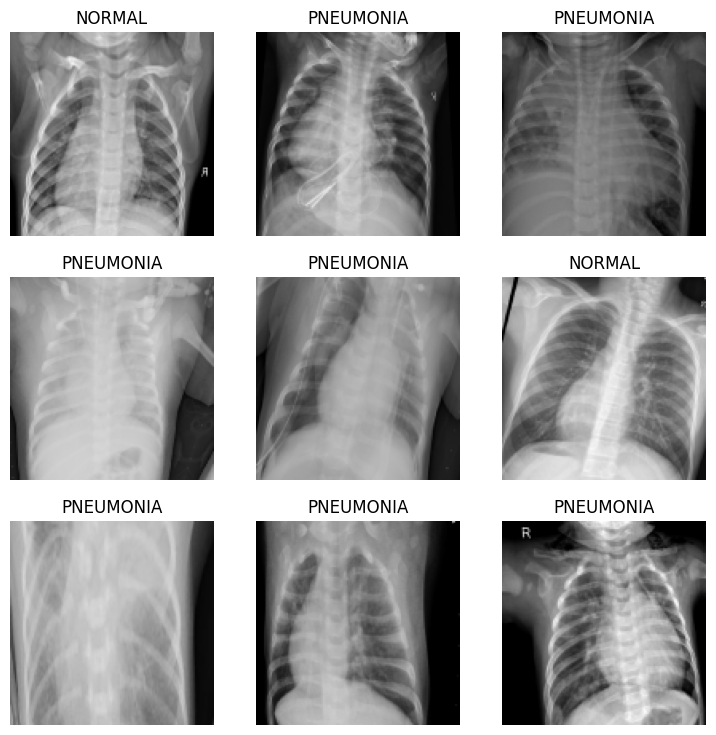

In [2]:
# Creando Train y Validation y rescalando las imágenes
dls = ImageDataLoaders.from_folder('./data/train', valid_pct=0.15, seed=42,
    item_tfms=Resize(480, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch(max_n=9)

## 2. Carga del Modelo

In [3]:
# Cargando el modelo prentrenado 'resnet 26d'
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

SuggestedLRs(valley=0.0030199517495930195, slide=0.007585775572806597)

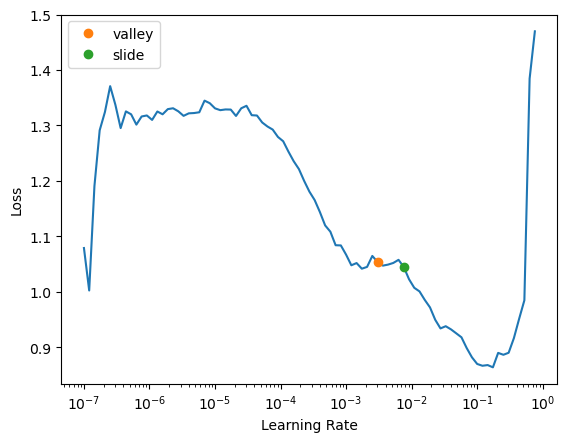

In [5]:
# Encontrando los mejores hiperparámetros
learn.lr_find(suggest_funcs=(valley, slide))

## 3. Entrenamiento del Modelo

In [6]:
learn.fine_tune(30,0.01)

## 4. Evaluación del Modelo

In [7]:
tst_files = get_image_files('./data/test').sorted()
tst_dl = dls.test_dl(tst_files)
print(tst_files[0:3])

[Path('data/test/NORMAL/IM-0017-0001.jpeg'), Path('data/test/NORMAL/IM-0084-0001.jpeg'), Path('data/test/NORMAL/IM-0087-0001.jpeg')]


In [8]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)

In [9]:
mapping = dict(enumerate(dls.vocab))
print(mapping)
reverse_mapping=dict(zip(dls.vocab,list(range(len(dls.vocab)))))
print(reverse_mapping)

{0: 'NORMAL', 1: 'PNEUMONIA'}
{'NORMAL': 0, 'PNEUMONIA': 1}


In [10]:
results = pd.Series(idxs.numpy(),name="idxs").map(mapping)
display(results)

0         NORMAL
1         NORMAL
2         NORMAL
3         NORMAL
4         NORMAL
         ...    
171    PNEUMONIA
172    PNEUMONIA
173    PNEUMONIA
174    PNEUMONIA
175    PNEUMONIA
Name: idxs, Length: 176, dtype: object

In [11]:
testY=[]
for item in tst_files:
    testY+=[reverse_mapping[item.parent.name]]

In [17]:
print(sk.classification_report(testY,idxs,target_names=dls.vocab,digits=4))

              precision    recall  f1-score   support

      NORMAL     0.9583    0.9583    0.9583        48
   PNEUMONIA     0.9844    0.9844    0.9844       128

    accuracy                         0.9773       176
   macro avg     0.9714    0.9714    0.9714       176
weighted avg     0.9773    0.9773    0.9773       176



## 5. Exportación del Modelo

In [18]:
learn.export('./models/CNN_Resnet.pkl')